In [ ]:
#mount the drive which you will be using this should be first step for every colab code which is using google drive data
#mounting will require authorization with the google account which the data is located, make sure to allow all
#glob will help you to collect all the images of a folder as a list and pass it to the desired fuction
from glob import glob
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
pip install tensorflow

In [ ]:
from PIL import Image
import os

def resize_images_in_place(folder_path, size=(600, 600)):
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".jpeg"):  # Check if the file is a JPEG
            file_path = os.path.join(folder_path, filename)
            with Image.open(file_path) as img:
                img = img.resize(size, Image.ANTIALIAS)
                img.save(file_path)  # Overwrite the original image

# Replace 'your/folder/path' with the path to your images folder
source_and_destination_folder = '/content/gdrive/MyDrive/FYP/binary_classification/healthy'
resize_images_in_place(source_and_destination_folder)


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras import layers, models, optimizers


In [ ]:
!ls '/content/gdrive/MyDrive/YOLO v8 models/brown rust VS stem rust VS loose smut/dataset//'

train  train.cache  val  val.cache


In [ ]:
# Set up directories
train_dir = '/content/gdrive/MyDrive/YOLO v8 models/brown rust VS stem rust VS loose smut/dataset/train/'
validation_dir = '/content/gdrive/MyDrive/YOLO v8 models/brown rust VS stem rust VS loose smut/dataset/val/'

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False
)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(640, 640),
    batch_size=32,
   class_mode='categorical'
)

Found 3336 images belonging to 3 classes.


In [ ]:
# test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(640, 640),
    batch_size=32,
    class_mode='categorical'
)

Found 964 images belonging to 3 classes.


In [ ]:
# Load the InceptionResNetV2 model
base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(640, 640, 3))
base_model.trainable = False  # Freeze the convolutional base


219055592/219055592 [==============================] - 11s 0us/step


In [ ]:
# Add custom classification layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # Multi-class classification
])


In [ ]:
# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
model.summary()

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,  # Adjust as needed
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

In [ ]:
import shutil

# Assuming 'history' is the folder you want to save to your Google Drive

# Define source and destination paths
source_path = '/path/to/history'  # Update this with the actual path of your history folder
destination_path = '/content/drive/MyDrive/history'  # Update this with the desired destination path in your Google Drive

# Copy the folder to Google Drive
shutil.copytree(source_path, destination_path)


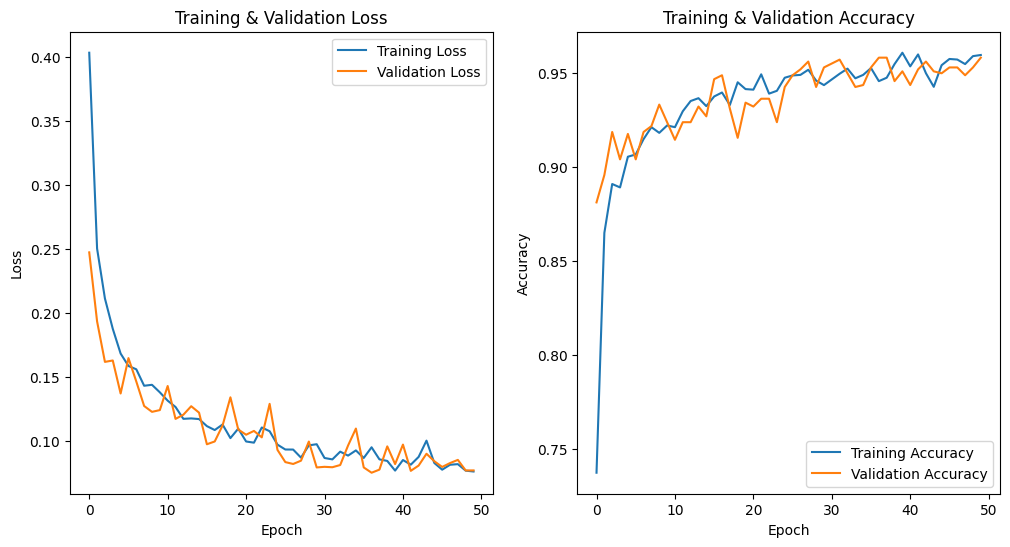

In [ ]:
import matplotlib.pyplot as plt

# 1. Visualize Training History
plt.figure(figsize=(12, 6))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training vs validation loss.jpg')

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('training vs validation accuracy.jpg')
plt.show()




In [ ]:
import pickle
import shutil

# Save history object to a file using pickle
with open('/content/gdrive/MyDrive/training_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)


In [ ]:
history.history

In [ ]:
from tensorflow.keras.models import save_model

# Assuming 'model' is your trained model
# Save the model after training
model.save('/content/gdrive/MyDrive/YOLO v8 models/brown rust VS stem rust VS loose smut/')


In [ ]:
# Assuming you have defined your ImageDataGenerators like this
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(640, 640), batch_size=32, class_mode='categorical')

# Fetch the label names and their corresponding label numbers
label_names = train_generator.class_indices
label_numbers = {v: k for k, v in label_names.items()}

# Print the label names and label numbers
print("Label Names:", label_names)
print("Label Numbers:", label_numbers)


Found 3336 images belonging to 3 classes.
Label Names: {'brown rust': 0, 'loose smut': 1, 'stem rust': 2}
Label Numbers: {0: 'brown rust', 1: 'loose smut', 2: 'stem rust'}


In [ ]:
 !ls '/content/gdrive/MyDrive/YOLO v8 models/brown rust VS stem rust VS loose smut/test/'

'brown rust'  'loose smut'  'stem rust'


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up the directory for test data
test_dir = '/content/gdrive/MyDrive/YOLO v8 models/brown rust VS stem rust VS loose smut/test/'

# Create an ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalize pixel values

# Create a generator for test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(640, 640),  # Resize images to match the input size of InceptionResNetV2
    batch_size=32,
    class_mode='categorical',  # or 'categorical' if you have multiple classes
    shuffle=False  # Ensure that data is not shuffled to match predictions with true labels
)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)


Found 496 images belonging to 3 classes.
16/16 [==============================] - 287s 19s/step - loss: 0.0877 - accuracy: 0.9556
Test Loss: 0.08774993568658829
Test Accuracy: 0.9556451439857483


Found 964 images belonging to 3 classes.
31/31 [==============================] - 50s 2s/step
[[301  16   9]
 [  4 307   2]
 [  6   3 316]]


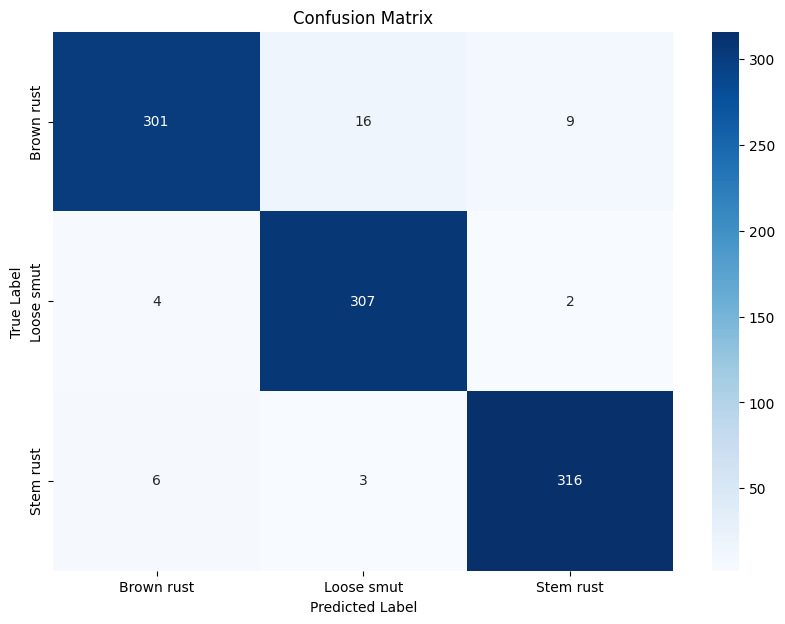

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming 'test_dir' is the directory containing your test dataset
test_dir = '/content/gdrive/MyDrive/YOLO v8 models/brown rust VS stem rust VS loose smut/dataset/val/'

test_datagen = ImageDataGenerator(rescale=1./255)

# Make sure to set shuffle=False to keep the data in order
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(640, 640),  # or the input size of your model
    batch_size=32,  # adjust based on your needs
    class_mode='categorical',  # or 'categorical' based on your problem
    shuffle=False
)

# Load your trained model
model = load_model('/content/gdrive/MyDrive/YOLO v8 models/brown rust VS stem rust VS loose smut/')


# Predict classes
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
# For multi-class classification, get the class with highest probability
predicted_classes = np.argmax(predictions, axis=1)

# Retrieve the true class labels
true_classes = test_generator.classes

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Print the confusion matrix
print(cm)

# If you need a more visual representation
import seaborn as sns
import matplotlib.pyplot as plt

# Define your class labels
class_labels = ['Brown rust', 'Loose smut', 'Stem rust']  # Replace with your actual class labels

# Assuming 'cm' is your confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig('confusion_matrix val.jpg')
plt.show()

